# Генерация данных и предсказание выгорания сотрудников IT-кампаний

## 1. Генерация сырых данных

In [1]:
# импорт библиотек для работы с таблицами и массивами
import pandas as pd
import numpy as np

# импорт библиотек для графиков
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
!pip install kaleido
import kaleido #required
kaleido.__version__ #0.2.1
import plotly
plotly.__version__ #5.5.0
# pio.templates.default = "plotly_dark"

# импорт библиотек для машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, metrics
from sklearn.svm import SVC
!pip install lightgbm
from lightgbm import LGBMClassifier
!pip install shap
import shap

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 23.2 MB/s eta 0:00:00


In [2]:
def create_worker(days, worker_id=0):
    # генерация дат
    tidx = pd.date_range('2022-03-11', periods=days, freq='D')
    time_data = pd.DataFrame({'date': tidx})

    # выделение дня недели и исключение суббот и воскресений
    time_data['dow'] = time_data['date'].dt.dayofweek
    time_data = time_data.query('dow != [5,6]')

    # количество рабочих дней за период
    row_count = time_data.shape[0]

    # генерация околопостоянных данных о сотруднике: таких как количество человек в команде, формат работы
    team_members = np.round(np.random.normal(8, 2)).astype(int)
    projects_amount = np.round(np.random.normal(3, 0.5)).astype(int)
    stek_amount = np.round(np.random.normal(5, 1)).astype(int)
    sport_player = np.random.randint(0, 2)
    job_format = np.random.randint(0, 2)

    # ----------------------

    # генерация более динамичных данных
    day_av_time = np.round(np.random.normal(8, 1, row_count)).astype(int)
    task_amount = np.round(np.random.normal(8, 2, row_count)).astype(int)
    ncomplited_task = np.round(np.random.normal(2, 0.5, row_count)).astype(int)
    avg_mess = np.round(np.random.normal(20, 3, row_count)).astype(int)

    # задаём долю вероятности выгораний сотрудника за период
    died_prob = np.random.uniform(0.93, 1)

    # генерируем массив с долей вероятности выше (сотрудник выгорел от 0.7 рабочих дней)
    died = np.random.choice([0, 1], size=row_count, p=[died_prob, 1 - died_prob])

    data = pd.DataFrame({'worker_id': worker_id, 'date': time_data['date'],'team_members': team_members, 'day_av_time': day_av_time,
                   'task_amount': task_amount, 'ncomplited_task': ncomplited_task, 'avg_mess': avg_mess, 'projects_amount': projects_amount,
                   'stek_amount': stek_amount, 'sport_player': sport_player, 'died': died})
    return data

In [3]:
# Создание и просмотр данных одного рабочего за 120 календарных дней
data_one_worker = create_worker(120)
data_one_worker.head()

,worker_id,date,team_members,day_av_time,task_amount,ncomplited_task,avg_mess,projects_amount,stek_amount,sport_player,died
0,0,2022-03-11,6,8,6,2,18,3,6,1,0
3,0,2022-03-14,6,8,10,2,16,3,6,1,0
4,0,2022-03-15,6,8,6,2,23,3,6,1,0
5,0,2022-03-16,6,8,11,1,16,3,6,1,0
6,0,2022-03-17,6,9,8,1,17,3,6,1,0


In [4]:
# создаём данные по отдельному работнику и объединяем в общую таблицу

data = pd.DataFrame()

# num в данном случае служит id работника
for num in range(100):
    data = data.append(create_worker(120, num))

# обновляем индексы
data = data.reset_index(drop=True)

In [5]:
# основная информация о получившемся сыром датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8600 entries, 0 to 8599
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   worker_id        8600 non-null   int64         
 1   date             8600 non-null   datetime64[ns]
 2   team_members     8600 non-null   int64         
 3   day_av_time      8600 non-null   int64         
 4   task_amount      8600 non-null   int64         
 5   ncomplited_task  8600 non-null   int64         
 6   avg_mess         8600 non-null   int64         
 7   projects_amount  8600 non-null   int64         
 8   stek_amount      8600 non-null   int64         
 9   sport_player     8600 non-null   int64         
 10  died             8600 non-null   int64         
dtypes: datetime64[ns](1), int64(10)
memory usage: 739.2 KB


## 2. Описание данных

- `worker_id` - id работника 
- `date` - дата наблюдения
- `team_members` - количество сотрудников в отделе
- `day_av_time` - среднее время работы за день
- `task_amount` - количество задач к исполнению
- `ncomplited_task` - количество невыполненных задач
- `avg_mess` - среднее количество сообщений
- `projects_amount` - количество проектов, в которых задействован сотрудник
- `stek_amount` - количество it-решений, используемых сотрудником
- `sport_player` - сотрудник занимается спортом (0 - нет, 1 - да)
- `died` - наличие эмоционального выгорания (0 - нет, 1 - да)

## 3. Генерация аномалий

In [6]:
# Генерируем аномалии которые служат триггерами к выгоранию

def create_anomaly(column, anomaly_value):
    # Получаем рандомный id записи во всей таблице
    rand_id = np.random.randint(0, data.shape[0])

    # перезаписываем данные ячейки на новые (аномальные) данные
    data.loc[rand_id, column] = anomaly_value
    return rand_id

id_data = []

# data_shape = data.shape[0]

# Создаём аномалии в ncomplited_task
for num in range(1023):
    # перезаписываем значение рандомной строчки указанного столбца на указанное (новое) ->
    # -> значение и записываем id изменённой строки в массив
    id_data.append(create_anomaly('ncomplited_task', np.round(np.random.uniform(8, 1)).astype(int)))

# Создаём аномалии в team_members
for num in range(235):
    id_data.append(create_anomaly('team_members', np.random.randint(1, 2)))

# Создаём аномалии в day_av_time
for num in range(666):
    id_data.append(create_anomaly('day_av_time', np.round(np.random.uniform(13, 3)).astype(int)))

# Создаём аномалии в avg_mess
for num in range(1228):
    id_data.append(create_anomaly('avg_mess', np.round(np.random.uniform(4, 14)).astype(int)))

# Создаём аномалии в stek_amount
for num in range(183):
    id_data.append(create_anomaly('stek_amount', np.round(np.random.uniform(9, 2)).astype(int)))

# Создаём аномалии в projects_amount
for num in range(500):
    id_data.append(create_anomaly('projects_amount', np.round(np.random.uniform(5, 2)).astype(int)))

In [7]:
print('Количество изменённых в ходе аномализации строк: ', len(id_data))
data.iloc[id_data].head(2)

Количество изменённых в ходе аномализации строк:  3835


,worker_id,date,team_members,day_av_time,task_amount,ncomplited_task,avg_mess,projects_amount,stek_amount,sport_player,died
5498,63,2022-07-01,8,7,10,1,21,5,4,1,0
8193,95,2022-04-13,5,9,6,6,15,3,7,1,0


## 4. Разметка данных

In [8]:
# Отбираем условия, по которым сотрудники будут "выгорать"

# Если в команде было 2 или меньше человек и количество задач было больше 9, то выгорание
data['died'] = np.where(
   (data['team_members'] <=2) & (data['task_amount'] >= 9) , 1, data['died']
   )

# Если сотрудник работал больше 10 часов и ему было необходимо было работать с более, чем 7 технологиями, то выгорание
data['died'] = np.where(
   (data['day_av_time'] >= 10) & (data['stek_amount'] >= 7) , 1, data['died']
   )

# Если у сотрудника было много невыполненных задач и он работал более, чем 9 часов, то выгорание
data['died'] = np.where(
   (data['ncomplited_task'] >= 5) & (data['day_av_time'] >= 9) , 1, data['died']
   )

# Если сотрудник работал на более, чем 4 проектах и много смсился, то выгорание
data['died'] = np.where(
   (data['projects_amount'] >= 4) & (data['avg_mess'] >= 5) , 1, data['died']
   )

# Если сотрудников в отделе было много, часов работы мало, а невыполненных задач мало, то не выгорание
data['died'] = np.where(
   (data['team_members'] >= 7) & (data['day_av_time'] <= 6) & (data['ncomplited_task'] <= 1) , 0, data['died']
   )

# Если сотрудник не занимается спортом и много работает то выгорание
data['died'] = np.where(
   (data['sport_player'] < 1) & (data['day_av_time'] >= 11) , 0, data['died']
   )

# Если сотрудник работал больше 13 часов, то выгорание
data['died'] = np.where(
   (data['team_members'] >= 1) & (data['day_av_time'] >= 13) , 0, data['died']
   )

In [9]:
# сохранение (при необходимости) данных в csv

# data.to_csv('100_workers_data.csv', index=False)

## 5. Анализ итоговых данных

In [10]:
data = pd.read_csv('workers_data.csv')

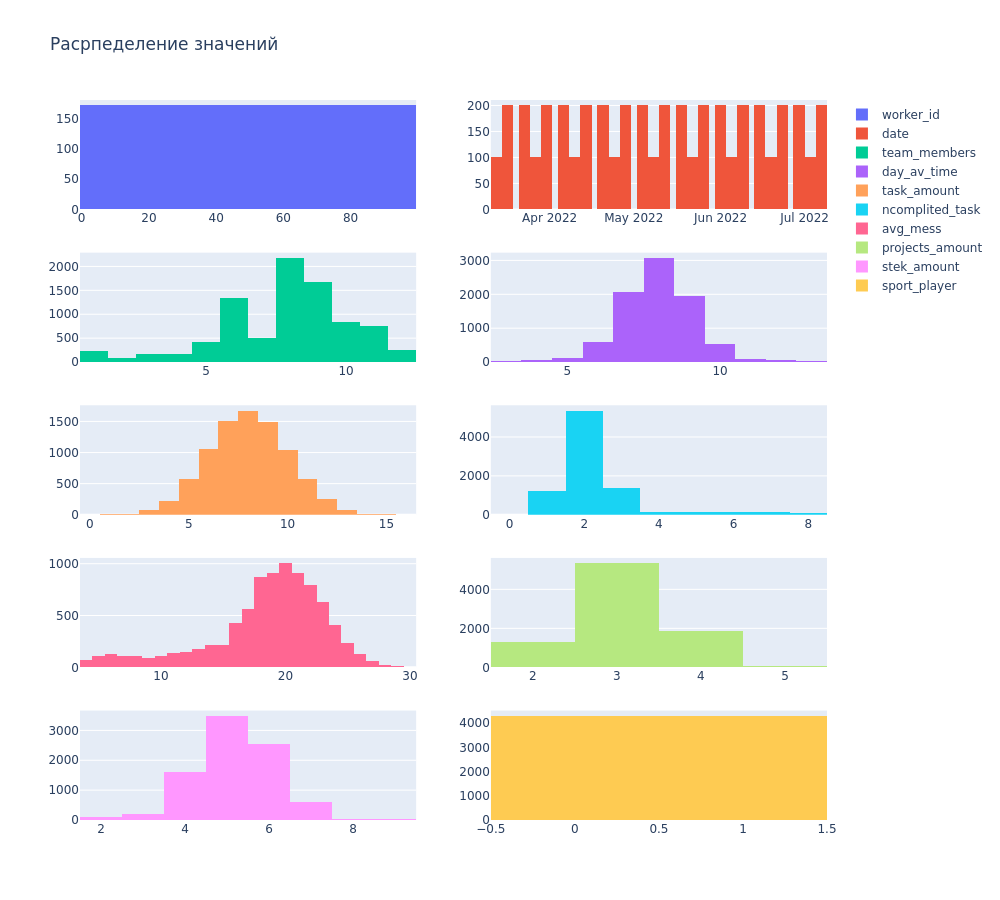

In [11]:
# Гистограммы для значений столбцов
fig = make_subplots(rows=int(len(data.columns) / 2), cols=2)

index = 0

for i in range(1, int((len(data.columns) / 2) + 1)):
    for j in range(1, 3):
        fig.add_trace(go.Histogram(x=data[data.columns[index]], name=data.columns[index], showlegend=True), row=i, col=j)
        index += 1

fig.update_layout(height=900, width=1000, title_text='Расрпеделение значений')
fig.show('png')

Большинство данных имеют нормальное распределение

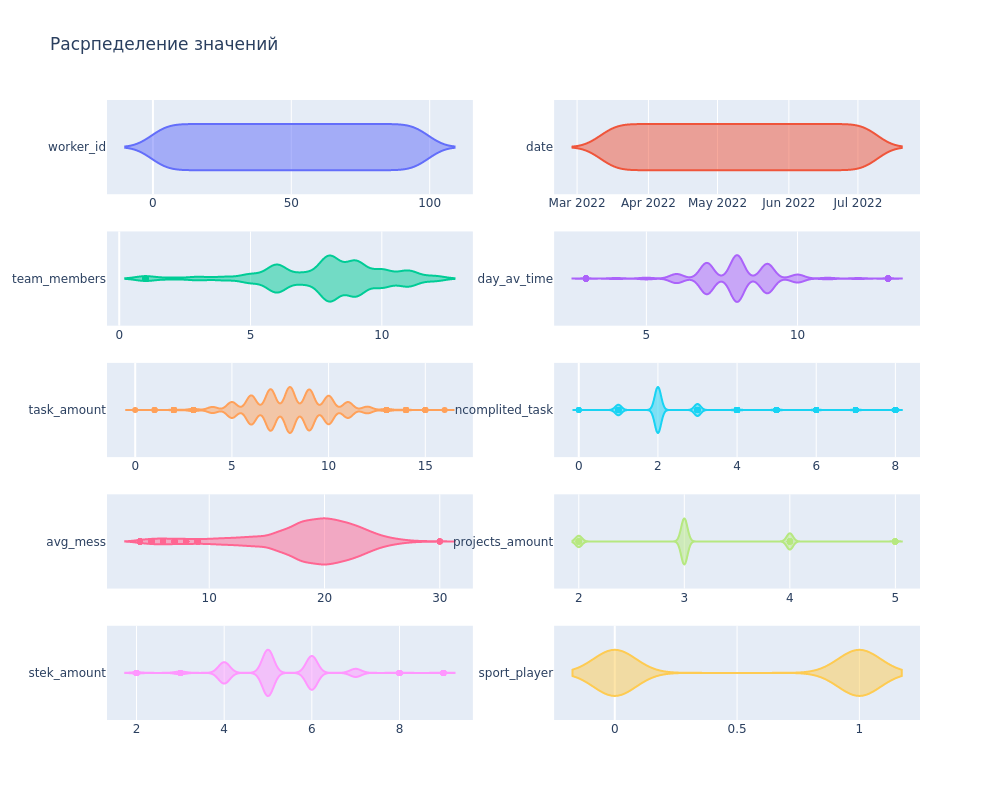

In [12]:
# Violin plots для значений столбцов
fig = make_subplots(rows=int(len(data.columns) / 2), cols=2)

index = 0

for i in range(1, int((len(data.columns) / 2) + 1)):
    for j in range(1, 3):
        fig.add_trace(go.Violin(x=data[data.columns[index]], name=data.columns[index], showlegend=False), row=i, col=j)
        index += 1
fig.update_layout(height=800, width=1000, title_text='Расрпеделение значений')
fig.show('png')

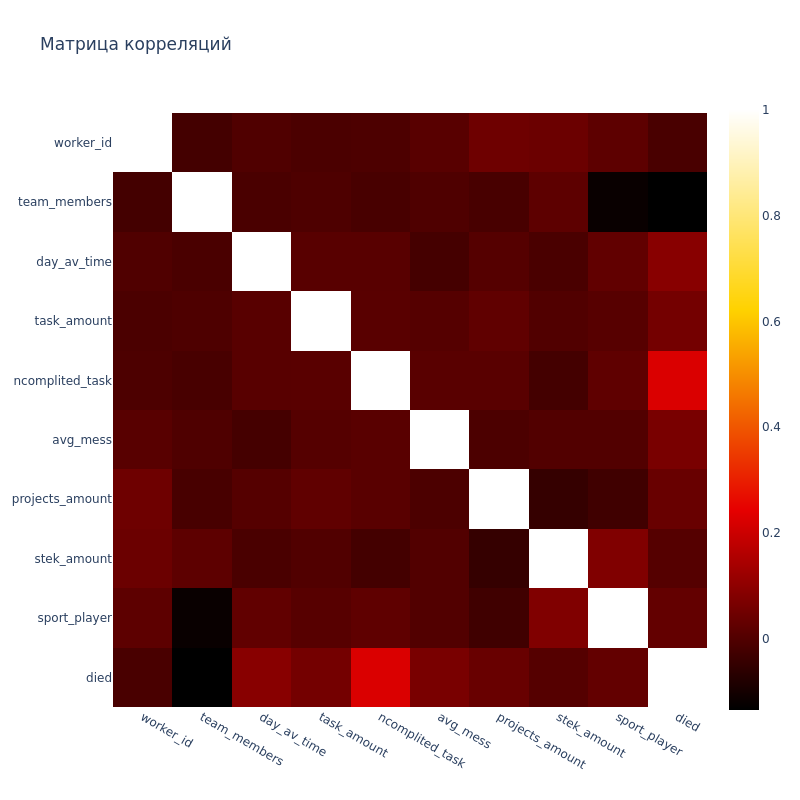

In [13]:
# построим и визуализируем корреляционную матрицу для получившихся данных
fig = px.imshow(data.corr(), color_continuous_scale='hot', title='Матрица корреляций', aspect='equal')
fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.show('png')

Сильная корреляция с эмоциональным выгоранием наблюдаются у количества незавершённых задач, что логично, поскольку если сотрудник не успевает в срок выполнить задачи недалеко и эмоциональное выгорание.

Также можно увидеть отрицательную корреляцию количества сотрудников в отделе с выгоранием: чем меньше сотрудников в отделе, тем больше задач приходится на одного сотрудника и, соответственно, тем выше шанс эмоционального выгорания.

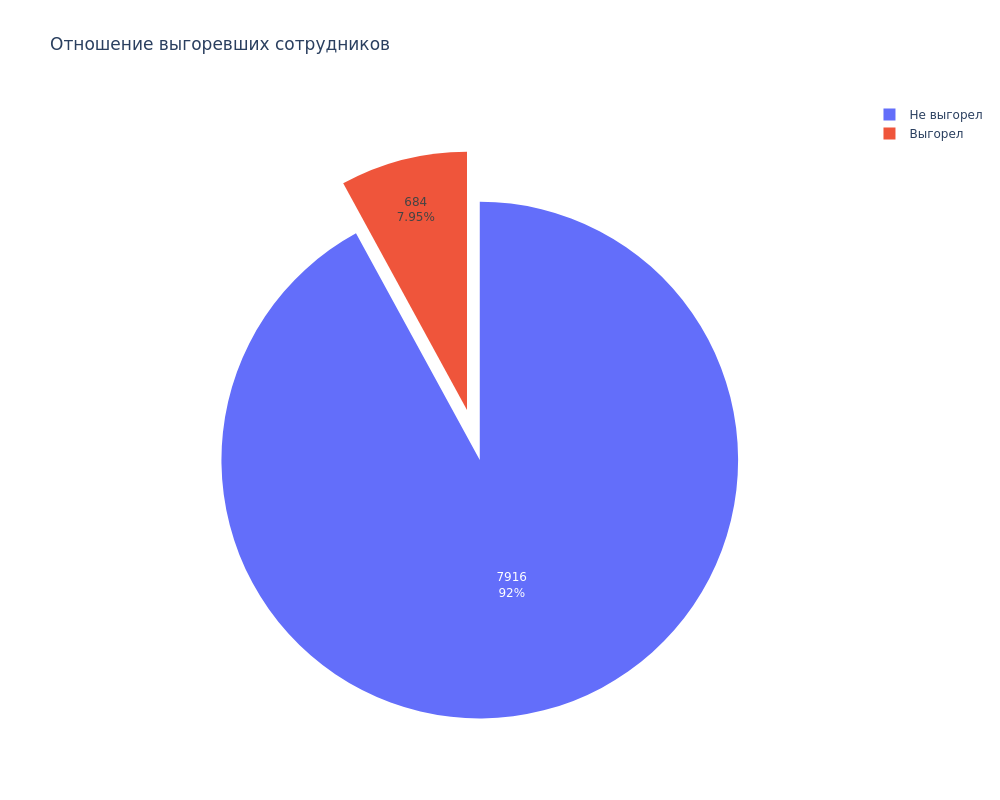

In [14]:
pie_data = data['died'].value_counts()

labels = ['Не выгорел','Выгорел']
fig = go.Figure(data=[go.Pie(labels=labels, values=pie_data, pull=[0.2, 0.0])])
fig.update_traces(textposition='inside', textinfo='percent+value')
fig.update_layout(height=800, width=1000, title_text='Отношение выгоревших сотрудников')
fig.show('png')

## 6. Обучение моделей машинного обучения (AutoML)

In [15]:
!pip install lazypredict
from lazypredict.Supervised import LazyClassifier

In [16]:
# отделяем фичи от целевого признака
x = data.drop(['died', 'worker_id', 'date'], axis=1)
y = data['died']

# разделяем данные на тестовые и валидационные в соотношении 75:25
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle=True)

In [17]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None)
models, predictions = clf.fit(x_train, x_test, y_train, y_test)
models

[07:50:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 29/29 [00:10<00:00,  2.88it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.96,0.78,0.78,0.96,0.58
LGBMClassifier,0.96,0.78,0.78,0.96,0.16
BaggingClassifier,0.96,0.78,0.78,0.95,0.12
RandomForestClassifier,0.96,0.78,0.78,0.95,0.53
DecisionTreeClassifier,0.92,0.76,0.76,0.92,0.03
ExtraTreesClassifier,0.94,0.70,0.70,0.93,0.50
QuadraticDiscriminantAnalysis,0.92,0.66,0.66,0.91,0.03
NearestCentroid,0.75,0.66,0.66,0.80,0.02
SVC,0.94,0.65,0.65,0.93,0.62


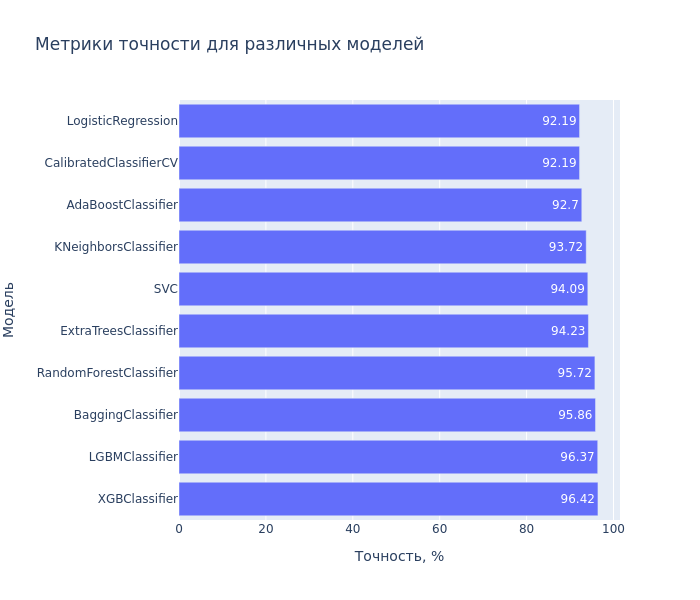

In [18]:
model_data = models.reset_index().sort_values(by='Accuracy', ascending=False).head(10)
model_data['Accuracy'] = round(model_data['Accuracy'] * 100, 2)

fig = px.bar(model_data, y='Model', x='Accuracy',
             title='Метрики точности для различных моделей', text_auto=True, height=600)
fig.update_xaxes(title='Точность, %')
fig.update_yaxes(title='Модель')
fig.show('png')

Таким образом, топ-3 моделей машинного обучения - LGBMClassifier, XGBClassifier и RandomForestClassifier

## 7. Обучение моделей машинного обучения (вручную)

Прогоним некоторые модели из списка вручную

In [19]:
# функция для отображения основных метрик моделей машинного обучения
def print_all_metrics(y_true, y_pred,  title='Metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))

# функция для отображения важности каждого признака модели
def print_importances(model):
    importances = model.feature_importances_
    print('\nВажность каждого признака для модели:')
    for feature, importance in zip(x.columns, importances):
        print(f"\t{feature}: {round(importance, 2)}")

In [20]:
DecisionTree_deep = tree.DecisionTreeClassifier(random_state=1, max_depth=24)

DecisionTree_deep.fit(x_train, y_train)

lr_predictions = DecisionTree_deep.predict(x_test)

lr_predictions_proba_deep = DecisionTree_deep.predict_proba(x_test)

print_all_metrics(
    y_test,
    lr_predictions,
    'Дерево решений (глубокое)'
)

print_importances(DecisionTree_deep)

Дерево решений (глубокое)
	Accuracy: 0.93
	Precision: 0.93
	Recall: 0.56
	F1: 0.93

Важность каждого признака для модели:
	team_members: 0.11
	day_av_time: 0.24
	task_amount: 0.2
	ncomplited_task: 0.13
	avg_mess: 0.16
	projects_amount: 0.12
	stek_amount: 0.03
	sport_player: 0.02


In [21]:
svm_model = SVC(kernel="linear", probability=True).fit(x_train,y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = svm_model.predict(x_test)

# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    title='Метрики для модели SVC:'
)

Метрики для модели SVC:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.00
	F1: 0.88


In [22]:
XGB_model = XGBClassifier().fit(x_train,y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = XGB_model.predict(x_test)

# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    title='Метрики для модели XGBoost:'
)

print_importances(XGB_model)

[07:51:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Метрики для модели XGBoost:
	Accuracy: 0.96
	Precision: 0.96
	Recall: 0.56
	F1: 0.96

Важность каждого признака для модели:
	team_members: 0.10000000149011612
	day_av_time: 0.1899999976158142
	task_amount: 0.11999999731779099
	ncomplited_task: 0.1599999964237213
	avg_mess: 0.07000000029802322
	projects_amount: 0.25
	stek_amount: 0.05000000074505806
	sport_player: 0.05999999865889549


In [23]:
LGBM_model = LGBMClassifier().fit(x_train,y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
LGBM_predictions = LGBM_model.predict(x_test)

# выведем все метрики
print_all_metrics(
    y_test,
    LGBM_predictions,
    title='Метрики для модели LGBMClassifier:'
)

Метрики для модели LGBMClassifier:
	Accuracy: 0.96
	Precision: 0.96
	Recall: 0.56
	F1: 0.96


## 8. Рассчёт вероятности эмоционального выгорания

### 8.1 Пример не выгоревшего сотрудника

Найдём вероятности отнесения сотрудника к тому или иному классу на основе новых данных.

Создадим сотрудника со следующими параметрами:

- Команда - 15 человек
- Среднее количество отработанных часов за день - 8
- Количество задач к исполнению - 6
- Количество невыполненных задач - 1
- Среднее количество сообщений - 20
- Количество проектов, в которых задействован сотрудник - 3
- Количество используемых IT-продуктов - 5
- Занимается спортом - да (1)

Должен будет получиться сотрудник, который достаточно "далёк" от эмоционального выгорания. "Новоиспеченный" сотрудник в большой команде, с малым количеством зада, занимается спортом. 

*В общем: спортсмен, комсомол и просто красавец :)*

In [24]:
good_worker = np.array([[15, 8, 6, 1, 20, 3, 5, 1]])
print('Вероятность выгорания равна:', round(XGB_model.predict_proba(good_worker)[0][1], 3))

Вероятность выгорания равна: 0.002


Как и ожидалось: вероятность выгореть минимальна

### 8.2 Пример выгоревшего сотрудника

Попробуем сгенерировать пример сотрудника, склонного к эмоциональному выгоранию:

- Команда - 2 человека
- Среднее количество отработанных часов за день - 10
- Количество задач к исполнению - 15
- Количество невыполненных задач - 7
- Среднее количество сообщений - 51 
- Количество проектов, в которых задействован сотрудник - 6
- Количество используемых IT-продуктов - 12
- Занимается спортом - нет (0)

Можно сразу предположить печальную участь данного бедолаги...

In [25]:
sad_worker = np.array([[2, 10, 15, 7, 51, 6, 12, 0]])
print('Вероятность выгорания равна:', round(XGB_model.predict_proba(sad_worker)[0][1], 3))

Вероятность выгорания равна: 1.0


Сотруднику явно приходится тяжко. Всего два человека в команде, задачи выполнять некому, так что невыполненные задачи плодяться как мухи в конюшне. Не удивительно что он не занимается спортом - некогда! 10 часов работать-то. Таким при жизни нужно памятник ставить.

## 9. Оценка вклада каждого из признаков

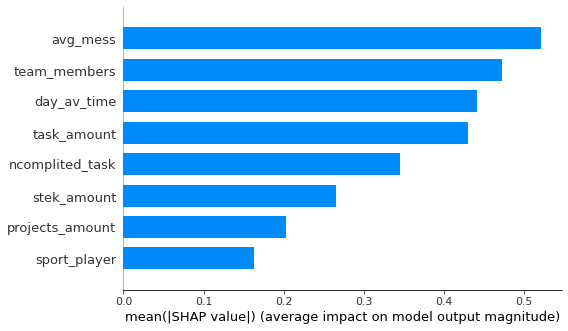

In [26]:
shap_values = shap.TreeExplainer(XGB_model).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

In [27]:
# Fits the explainer
explainer = shap.Explainer(XGB_model.predict, x_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)

Exact explainer: 2151it [01:35, 21.02it/s]                          


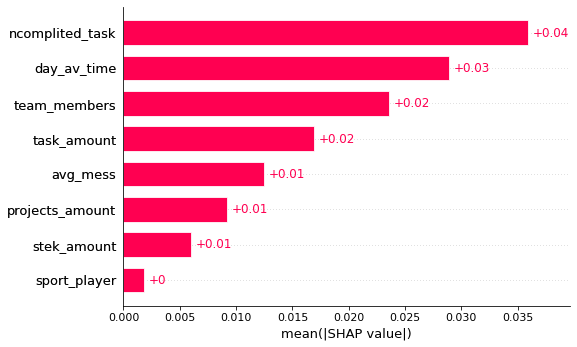

In [28]:
shap.plots.bar(shap_values)

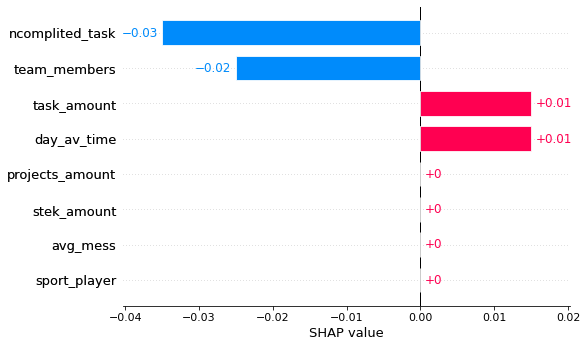

In [29]:
shap.plots.bar(shap_values[0])

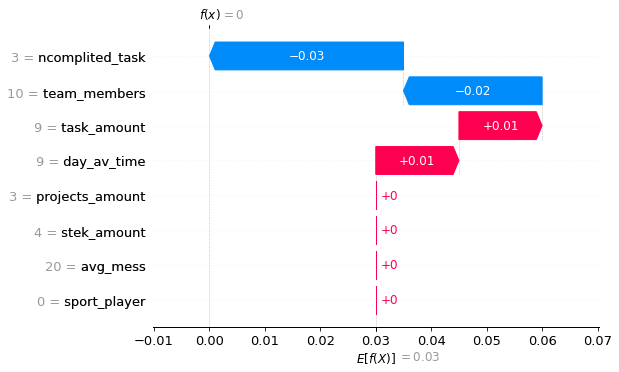

In [30]:
shap.plots.waterfall(shap_values[0])

## 10. Оценка вклада признаков для новых предсказаний

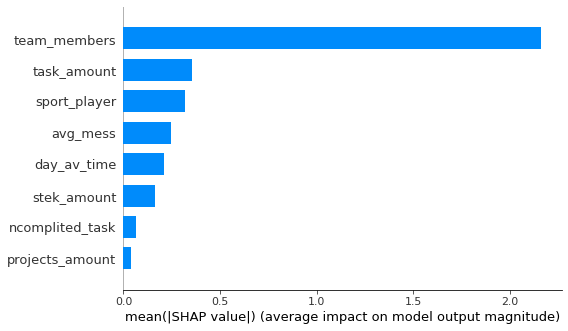

In [31]:
# создаем объект explainer для нашей модели и обучающих данных
explainer = shap.Explainer(XGB_model, x_train)

# рассчитываем SHAP значения для новых данных
shap_values = explainer(good_worker)

feature_names = ['team_members',
	'day_av_time',
	'task_amount',
	'ncomplited_task',
	'avg_mess',
	'projects_amount',
	'stek_amount',
	'sport_player']

# выводим вклад каждого признака для каждого объекта
shap.summary_plot(shap_values, good_worker, plot_type="bar", feature_names=feature_names)

Как можно увидеть, наибольший вклад внесло количество сотрудников в команде. Видимо, чем их больше, тем веселей/комфортней нашему сотруднику, и тем меньше шанс выгорания.

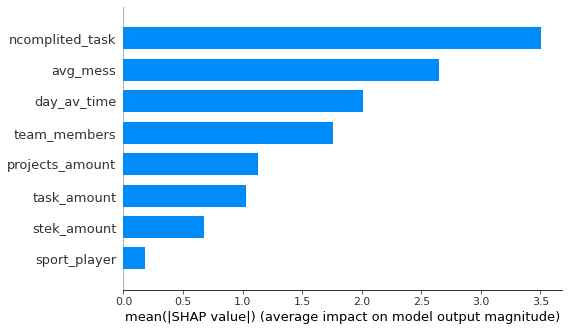

In [36]:
# создаем объект explainer для нашей модели и обучающих данных
explainer = shap.Explainer(XGB_model, x_train)

# рассчитываем SHAP значения для новых данных
shap_values = explainer(sad_worker)

# выводим вклад каждого признака для каждого объекта
shap.summary_plot(shap_values, sad_worker, plot_type="bar", feature_names=feature_names)

В данном случае решающих факторов оказалось гораздо больше для выгорания. Самый главный из них - количество невыполненных задач